In [102]:
import sys 
sys.path.append('..')

import quarantines as Q
from pymongo import MongoClient 
import numpy as np 
import matplotlib.pyplot as plt 
import quarantines_mongo as qm 
from bson.objectid import ObjectId

In [2]:
client = MongoClient('10.157.90.169', 27017)
db = client.quarantines20


In [ ]:
# Just do the joins manually b/c the data is actually pretty small... 

In [87]:
# Step 1 -- collect all the {graph_id, epidemic_id, max_Is, final_Rs}
test_vanilla = db.vanilla_runs.find_one()
print(test_vanilla.keys())

dict_keys(['_id', 'graph_id', 'epidemic_id', 'num_runs', 'max_Is', 'final_Rs', 'full_data'])


In [88]:
vanilla_docs = list(db.vanilla_runs.find(projection={'graph_id': 1, 'epidemic_id': 1, 'max_Is': 1, 'final_Rs': 1}))

In [89]:
# and collect relevant graph_ids and epidemic_ids in a set 
rel_graphs = set(_['graph_id'] for _ in vanilla_docs)
rel_epis = set(_['epidemic_id'] for _ in vanilla_docs)

In [105]:
# Step 2: collect and index the graphs:
graph_lookup = {}
for doc in db.graphs.find():
    if doc['process'] != 'powerlaw_cluster': 
        continue 
    new_graph = {'_id': doc['_id'], 
                 'N': doc['N'], 
                 'm': doc['params']['m'], 
                 'p': doc['params']['p']}
    graph_lookup[doc['_id']] = new_graph 


In [106]:
# Step 3: collect and index the epidemics:
epi_lookup = {} 
for doc in db.epidemics.find():
    if doc['_id'] not in rel_epis:
        continue 
    epi_lookup[doc['_id']] = doc

In [112]:
# Step 4: unfold each setting into a valid run: 
unfold_docs = []
for doc in vanilla_docs:
    if doc['graph_id'] not in graph_lookup:
        print(doc['graph_id'])
        continue
    new_doc = {}
    new_doc.update(doc)
    
    new_doc.update(graph_lookup[doc['graph_id']])
    new_doc.update(epi_lookup[doc['epidemic_id']])
    new_doc['avg_final_R'] = avg(new_doc['final_Rs'])
    new_doc['avg_max_I'] = avg(new_doc['max_Is'])
    unfold_docs.append(new_doc)

In [118]:
# Now looking at data: 
# What do I want to plot...
def minmax(doclist, field, min_or_max):
    assert min_or_max in [min, max]
    return min_or_max(doclist, key=lambda d: d[field])

In [123]:
def filter_(doclist, conds):
    output = []
    for doc in doclist:
        if all(doc[k] == v for k,v in conds.items()):
            output.append(doc)
            
    return output


In [125]:
unfold_docs[0]

{'_id': ObjectId('5f2839901217efb261a22cdc'),
 'graph_id': ObjectId('5f2839901217efb261a22cdb'),
 'epidemic_id': ObjectId('5f2839901217efb261a22cdc'),
 'max_Is': [3073, 3244, 3262, 3098, 3170],
 'final_Rs': [7882, 7932, 7861, 7621, 7878],
 'N': 10000,
 'm': 2,
 'p': 0.01,
 'tau': 0.05,
 'gamma': 0.05,
 'rho': 0.005,
 'avg_final_R': 7834.8,
 'avg_max_I': 3169.4}

In [143]:
m8 = filter_(unfold_docs, {'m': 8})

In [146]:
aggs = {}
for doc in m8:
    k = (doc['tau'], doc['gamma'])
    if k not in aggs:
        aggs[k] = [] 
    aggs[k].append({'p': doc['p'], 'R': doc['avg_final_R'], 'I': doc['avg_max_I']})

In [147]:
for el in sorted(aggs.items(), key=lambda p: p[0]):
    print(el)

((0.05, 0.05), [{'p': 0.01, 'R': 9989.6, 'I': 7164.6}, {'p': 0.02, 'R': 9986.2, 'I': 7193.4}, {'p': 0.05, 'R': 9988.4, 'I': 7183.6}, {'p': 0.1, 'R': 9989.0, 'I': 7167.4}, {'p': 0.25, 'R': 9987.2, 'I': 7204.0}])
((0.05, 0.1), [{'p': 0.01, 'R': 9855.6, 'I': 5722.2}, {'p': 0.02, 'R': 9834.0, 'I': 5635.8}, {'p': 0.05, 'R': 9844.2, 'I': 5680.6}, {'p': 0.1, 'R': 9826.0, 'I': 5660.6}, {'p': 0.25, 'R': 9829.6, 'I': 5680.8}])
((0.05, 0.15), [{'p': 0.01, 'R': 9467.6, 'I': 4613.8}, {'p': 0.02, 'R': 9496.2, 'I': 4570.4}, {'p': 0.05, 'R': 9513.0, 'I': 4659.4}, {'p': 0.1, 'R': 9519.2, 'I': 4643.8}, {'p': 0.25, 'R': 9469.4, 'I': 4616.6}])
((0.05, 0.2), [{'p': 0.01, 'R': 9035.6, 'I': 3842.6}, {'p': 0.02, 'R': 9019.8, 'I': 3815.6}, {'p': 0.05, 'R': 9030.4, 'I': 3798.6}, {'p': 0.1, 'R': 9003.4, 'I': 3759.8}, {'p': 0.25, 'R': 8961.2, 'I': 3802.2}])
((0.05, 0.25), [{'p': 0.01, 'R': 8457.0, 'I': 3114.0}, {'p': 0.02, 'R': 8485.2, 'I': 3209.4}, {'p': 0.05, 'R': 8440.2, 'I': 3182.2}, {'p': 0.1, 'R': 8387.4, '

In [148]:
# Observation 1: number of finalR/maxI doesn't hinge much on p 


In [176]:
# Maybe fix a gamma/tau and look at heatmaps 
def gamma_tau_heatmap(doclist, m):
    # First collect graphs by M
    docs = filter_(doclist, {'m': m})
    # and group by tau/gamma
    taugamma = {} 
    for doc in docs:
        k = (doc['tau'], doc['gamma'])
        if k not in taugamma:
            taugamma[k] = [] 
        taugamma[k].append(doc['avg_final_R'])
    
    agg_taugamma = {}
    for k, v in taugamma.items():
        agg_taugamma[k] = avg(v)
    p0, p1, grid = heatmap_from_trips(agg_taugamma)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title("M: %s" % m)
    sns.heatmap(grid, xticklabels=p1, yticklabels=p0, ax=ax, vmin=0, vmax=10000)
    return ax
    

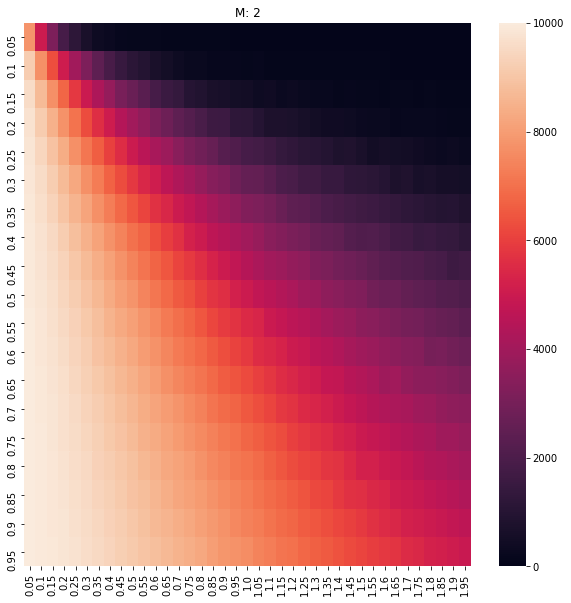

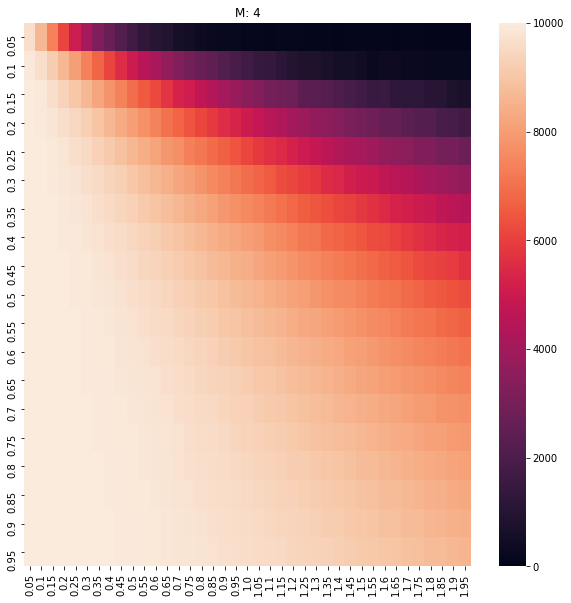

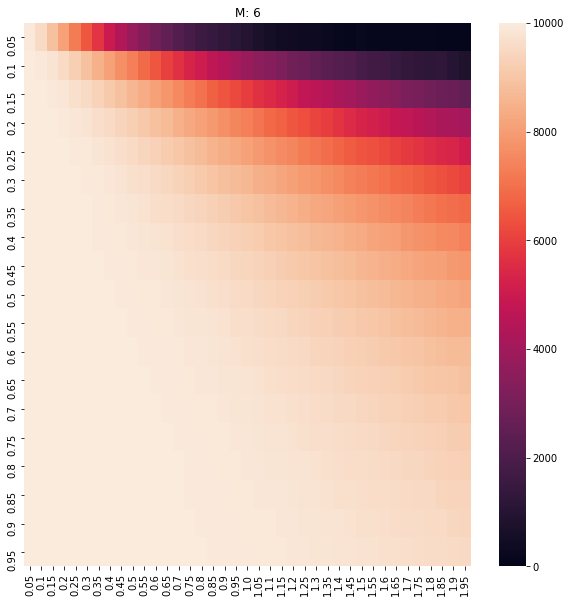

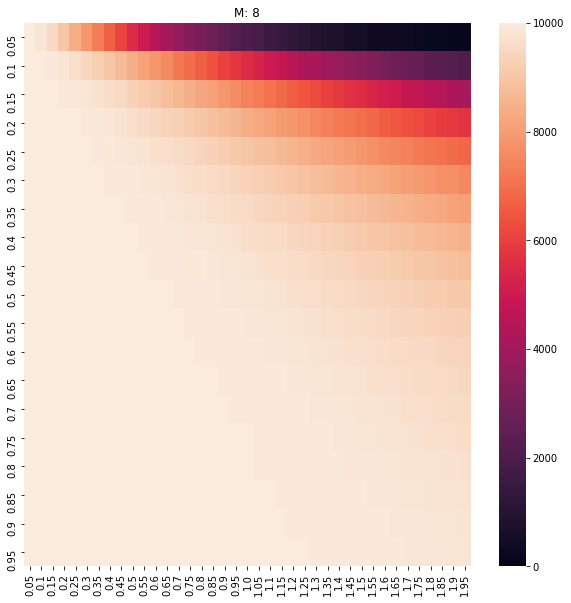

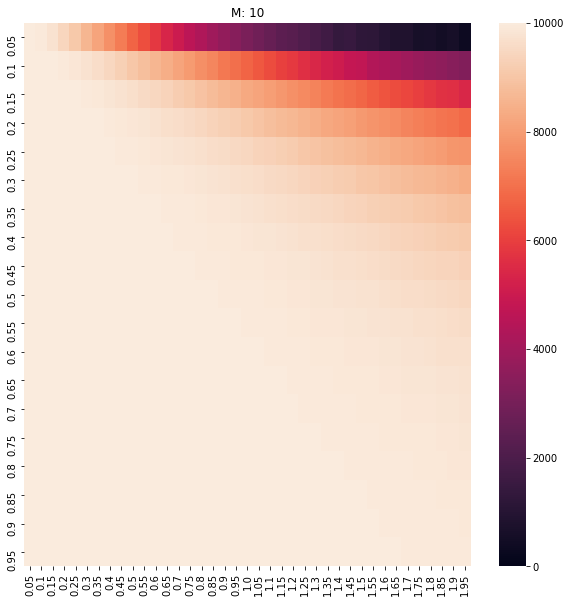

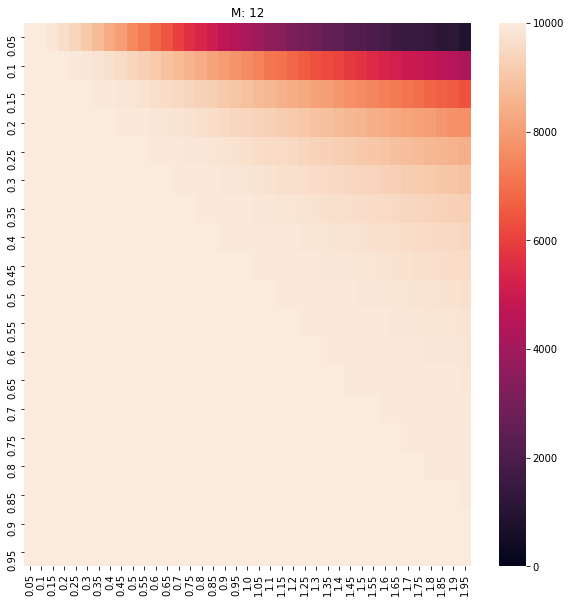

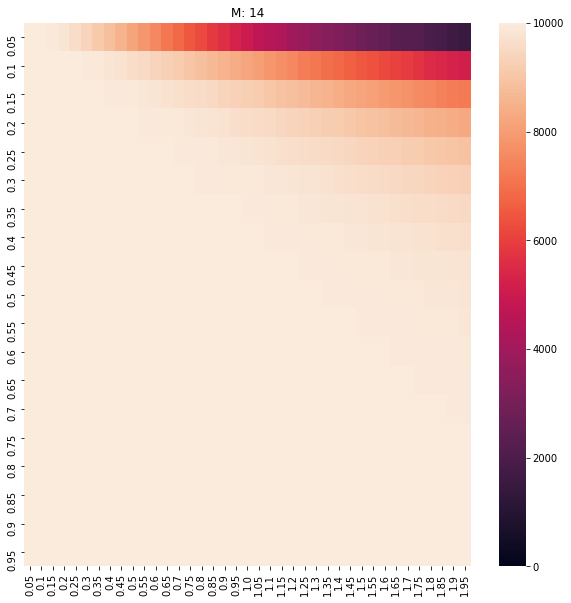

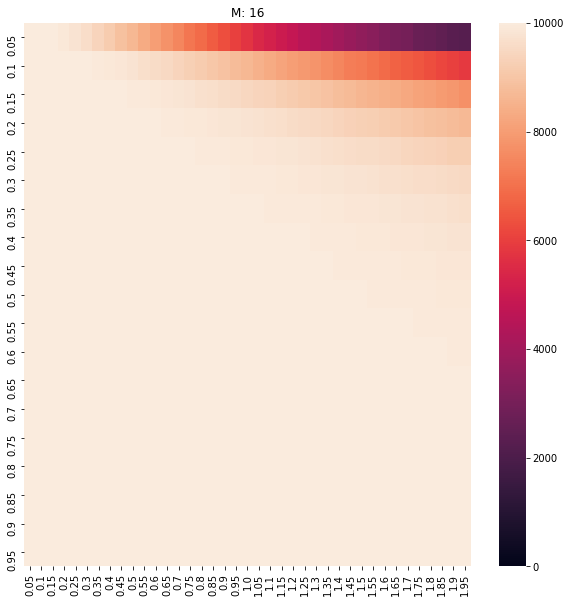

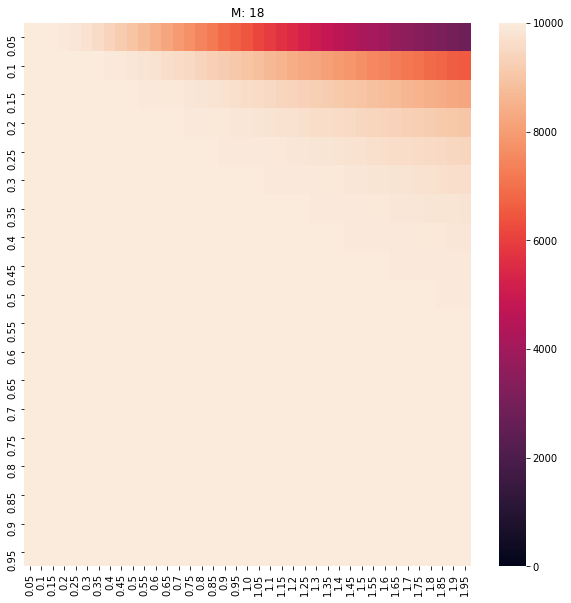

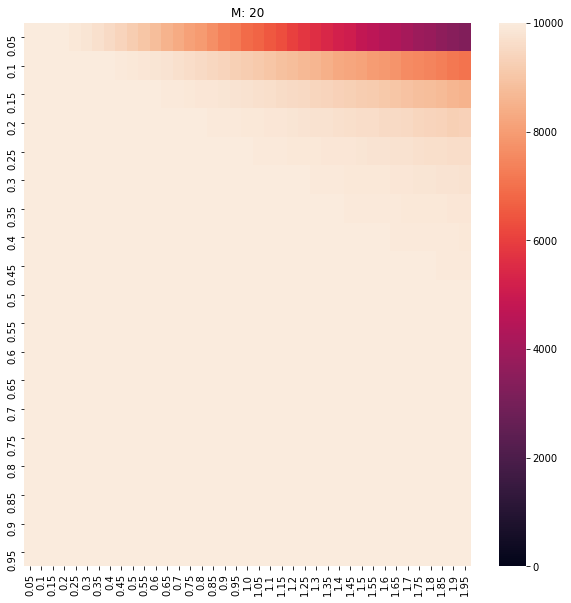

In [177]:
for m in [_ * 2 for _ in range(1, 11)]:
    gamma_tau_heatmap(unfold_docs, m)

In [157]:
def heatmap_from_trips(tripdict):
    p0_keys = sorted(set(_[0] for _ in tripdict.keys()))
    p1_keys = sorted(set(_[1] for _ in tripdict.keys()))
    
    grid = np.zeros((len(p0_keys), len(p1_keys)))
    for i, el0 in enumerate(p0_keys):
        for j, el1 in enumerate(p1_keys):
            if (el0, el1) in tripdict:
                grid[i][j] = tripdict[(el0, el1)]
    return p0_keys, p1_keys, grid

In [159]:
import seaborn as sns

In [160]:
p0, p1, grid = heatmap_from_trips(gt8)

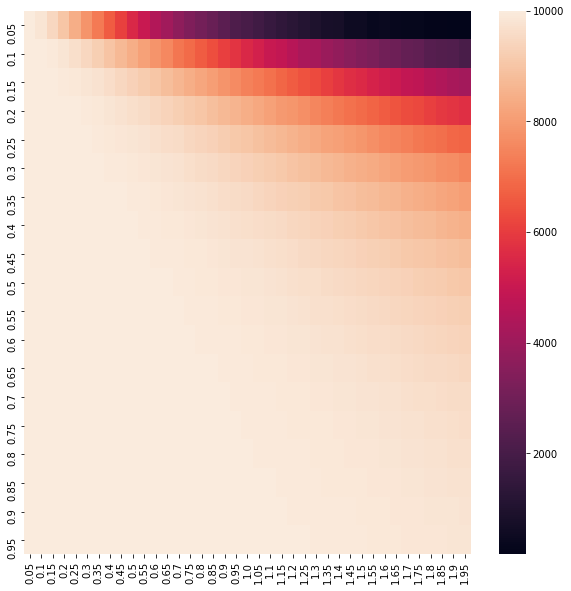